# Imports

In [213]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation, utils
from scipy import fftpack
from matplotlib import pyplot as plt
from enum import Enum, auto


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Regular simulation settings

In [214]:
amplitude = 10000
sim_wavelength = 488e-9
sim_width = 1000e-6
pixel_size = 0.1e-6
output_medium = Lens.Medium(1.33)

### Convergence/Divergence Class/Functions

In [255]:
class BeamSpread(Enum):
    Plane = auto()
    Diverging = auto()
    Converging = auto()

class DistanceMode(Enum):
    Direct = auto()
    Width = auto()

def theta_from_NA(numerical_aperture: float, output_medium: Lens.Medium):
    import numpy as np
    return np.arcsin(numerical_aperture/output_medium.refractive_index)

def focal_distance_from_theta(aperture: Lens, theta: float):
    return aperture.diameter/2 / np.tan(theta)

def height_from_focal_distance(aperture: Lens, output_medium: Lens.Medium, focal_distance: float):
    a = 1
    b = -2*focal_distance*(aperture.medium.refractive_index-output_medium.refractive_index)/output_medium.refractive_index
    c = (aperture.diameter/2)**2

    if (b**2 - 4*a*c < 0):
        raise ValueError("Negative value encountered in sqrt.  Can't find a lens height to give this focal distance")
    else: return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

### Aperture/Beam definition

In [284]:
# Beam settings chosen by user
aperture_width = 400e-6
# position given relative to optical axis
aperture_position = -100e-6

# this is selected by DistanceMode flag in config
distance_mode = DistanceMode.Width

# type of beam spread
beam_spread = BeamSpread.Converging

# calculate theta for non plane waves
if beam_spread is not BeamSpread.Plane:
    # Theta can either be specified directly, or by numerical aperture (config flag probably)
    theta = np.deg2rad(10) 
    # OR
    theta = theta_from_NA(numerical_aperture=0.4, output_medium=output_medium)

# perpendicular distance of source from the first lens can be defined directly (aperture distance) 
# or based on a desired beam width at the lens plane 
source_aperture_distance = 200e-6
final_beam_width = 80e-6
if beam_spread is BeamSpread.Plane:
    final_beam_width = aperture_width

# set tilt enabled based off flag
tilt_enabled = True
tilt_angle = np.deg2rad(85)

# Default beam specifications
aperture = Lens.Lens(
    diameter=aperture_width,
    height=0.,
    exponent=2,
    medium=Lens.Medium(100)
)

# ERROR CHECKING #
# quick check on aperture validity
if (aperture_position + aperture_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
# if using diverging beam spread and DistanceMode.Width, the aperture must be smaller than the final_width
if beam_spread is BeamSpread.Diverging and distance_mode is DistanceMode.Width and final_beam_width < aperture_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')
# likewise for using converging beam spread and DistanceMode.Width, the aperture must be larger than the final_width
if beam_spread is BeamSpread.Converging and distance_mode is DistanceMode.Width and final_beam_width > aperture_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')


#### Calculation of Convergence/Divergence

In [285]:
if beam_spread is not BeamSpread.Plane:
    # calculate the equivalent focal distance of the required convergence angle
    focal_distance = focal_distance_from_theta(aperture=aperture, theta=theta)

    # calculate and set the height of the apertures 'virtual' lens, re-generate the profile with new height
    aperture.height = height_from_focal_distance(aperture, output_medium=output_medium, focal_distance=focal_distance)
    
    printing = False
    if printing:
        # Just some debugging prints, can remove if you want
        print(f'Angle of convergence: {np.rad2deg(theta)}')
        print(f'Focal distance wanted: {round(focal_distance*1e3, 3)}mm')
        print(f'Aperture height: {round(aperture.height*1e6, 3)}um')
        print(f'New Focal Distance: {round(Simulation.calculate_equivalent_focal_distance(aperture, output_medium)*1e3, 3)}mm')

aperture.generate_profile(pixel_size=pixel_size)

# possibly just invert lens
if beam_spread is BeamSpread.Diverging:
    aperture.profile = -aperture.profile + np.max(aperture.profile) 

### Calculation of aperture position and padding

In [286]:

# calculate the relative position of the aperture in pixels
relative_position = int(aperture_position/pixel_size)

# pad the aperture to the sim width
# plus one here is to make it 10001, not 9999
pad_width = (int(sim_width/pixel_size)-len(aperture.profile))//2 + 1 

# update the aperture profile
aperture.profile = np.pad(aperture.profile, (pad_width+relative_position, pad_width-relative_position), 'constant', constant_values=(0))
# plt.plot(aperture.profile)

#### Calculation of Propagation Distance

In [287]:
# Start distance of beam always = 0
start_distance = 0

# If you just want the source to be a certain distance away:
if distance_mode is DistanceMode.Direct or beam_spread is BeamSpread.Plane:
    finish_distance = source_aperture_distance

# if you want the beam to converge/diverge to a specific width
elif distance_mode is DistanceMode.Width:
    beam_radius = final_beam_width/2
    if beam_spread is BeamSpread.Converging:
        finish_distance = focal_distance - (beam_radius/np.tan(theta))
    else:
        finish_distance = ((beam_radius-(aperture.diameter/2))/np.tan(theta))
else:
    raise ValueError('DistanceMode set incorrectly')

### Delta, Tilt, Phase

In [288]:
# regular delta calculation
delta = (aperture.medium.refractive_index-output_medium.refractive_index) * aperture.profile

# tilt the beam
if tilt_enabled:
    x = np.arange(len(aperture.profile))*pixel_size
    # modify the optical path of the light based on tilt
    delta = delta + x * np.tan(np.deg2rad(15))

# regular phase calculation
phase = (2 * np.pi * delta / sim_wavelength)# % (2 * np.pi)

### Wavefront Calculation

In [289]:
# regular wavefront calculation
wavefront = amplitude * np.exp(1j * phase)

# asymmetric aperturing (apply aperture mask)
wavefront[:pad_width + relative_position] = 0 + 0j
wavefront[-(pad_width - relative_position):] = 0 + 0j

# regular wavefront FFT
wavefront = fftpack.fft(wavefront)

### Simulation

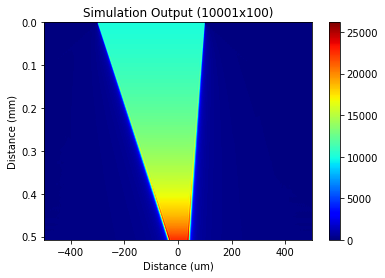

In [290]:
# regular frequency array creation
frequency_array = Simulation.generate_squared_frequency_array(n_pixels=len(aperture.profile), pixel_size=pixel_size)

n_slices_1 = 100

sim = np.ones(shape=((n_slices_1), len(aperture.profile)))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim[i] = np.round(output, 10)


utils.plot_simulation(sim, sim.shape[1], sim.shape[0], pixel_size, start_distance, finish_distance)
plt.show()